# Clinical Data Analysis

In [1]:
!python --version

Python 3.10.12


In [2]:
!pip -qq install synapseclient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00


In [3]:
!wget -qq https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf -O arial.ttf
!wget -qq https://github.com/foursquare/foursquair/raw/master/src/assets/fonts/Arial%20Bold.ttf -O arial_bold.ttf

In [4]:
import cv2
import yaml
import math
import random
import pickle
import numpy as np
import pandas as pd
import synapseclient
from enum import Enum
from tqdm import tqdm
from random import seed
from collections import Counter
seed(10)

import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw, ImageFont

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from typing import List
from dataclasses import dataclass
from abc import ABC, abstractmethod
from IPython.display import display

pd.set_option('display.max_columns', None)

`config.yaml` should be kept in the same directory of the notebooks and be prepared like this.

    auth_token: YOUR_AUTH_TOKEN_HERE

Please go to synapse and log in to get the authentication token. Without `config.yaml` you will not be able to execute the following code.

In [6]:
def get_auth_token_from_yaml(file_path='config.yaml'):
    with open(file_path, 'r') as file:
        config_data = yaml.safe_load(file)
        auth_token = config_data.get('auth_token')
        return auth_token

auth_token = get_auth_token_from_yaml()
syn = synapseclient.Synapse()
syn.login(authToken=auth_token)

Welcome, fuad021!



INFO:synapseclient_default:Welcome, fuad021!



## Patients and Recurrences

In [7]:
syn31123117 = syn.get(entity='syn31123117')

df = pd.read_csv(syn31123117.path, sep='\t')
df = df.fillna(0)
df = df.set_index('Gene_symbol')

df

,GLSS.SM.R109.TP.01R.RNA.I4HTPP,GLSS.19.0274.TP.01R.RNA.ZZD8PZ,GLSS.CU.R005.TP.01R.RNA.LOURPF,GLSS.SM.R060.TP.01R.RNA.ZI9YVM,GLSS.MD.0017.R2.01R.RNA.L5HMEO,GLSS.HF.47E9.R1.01R.RNA.7W5GMH,TCGA.TQ.A8XE.TP.11R.RNA.0YPLAZ,GLSS.LU.00C2.TP.01R.RNA.2QRUOC,GLSS.HF.CB66.TP.01R.RNA.9MRJMX,GLSS.LU.00B9.R1.01R.RNA.1IVJNJ,TCGA.06.0210.TP.01R.RNA.JMBENW,TCGA.DU.7304.R1.12R.RNA.OMXRQS,GLSS.SN.0001.R1.01R.RNA.PZAYRK,GLSS.MD.0022.TP.01R.RNA.EDOJNO,GLSS.19.0267.R1.01R.RNA.NCCNA9,TCGA.TQ.A7RK.R2.11R.RNA.BJMJ93,GLSS.HF.DF35.TP.01R.RNA.IH1LVD,TCGA.06.0221.R1.11R.RNA.UCUX3T,GLSS.MD.0048.R1.01R.RNA.RVQU3C,GLSS.HF.6504.TP.01R.RNA.5OSIEV,GLSS.CU.P024.TP.01R.RNA.8JTL48,GLSS.HF.4F0A.TP.01R.RNA.GG6762,GLSS.SM.R107.TP.01R.RNA.ZSYP37,GLSS.CU.R009.R1.01R.RNA.QREUYE,TCGA.FG.5965.R2.11R.RNA.UCBSIY,TCGA.FG.5963.R1.12R.RNA.1EJ1SV,GLSS.CU.P104.R1.01R.RNA.L5UZ2L,GLSS.HF.B30B.R2.01R.RNA.K9X72E,GLSS.MD.0046.R1.01R.RNA.Y7WTHG,GLSS.SN.0017.TP.01R.RNA.FX5HYW,GLSS.MD.0017.R1.01R.RNA.8FU0BP,GLSS.SM.R070.TP.01R.RNA.QWG60O,GLSS.LU.00C7.R1.01R.RNA.898J17,GLSS.SM.R101.R1.01R.RNA.7ATA59,GLSS.MD.0012.R1.01R.RNA.GB101L,GLSS.HF.2869.TP.01R.RNA.2H6MOF,GLSS.MD.0027.R1.01R.RNA.E771C5,GLSS.MD.0044.TP.01R.RNA.2ARML9,GLSS.CU.P069.TP.01R.RNA.CVOV9T,GLSS.SM.R101.TP.02R.RNA.V4TRVD,TCGA.19.0957.R1.01R.RNA.7WHBFU,GLSS.SN.0009.TP.01R.RNA.1DY2G0,GLSS.19.0279.R2.01R.RNA.G733J7,GLSS.HK.0004.R1.01R.RNA.1PAW5U,GLSS.LU.00C7.TP.01R.RNA.7QCLSN,GLSS.19.0271.R1.01R.RNA.ZGQFM3,GLSS.19.0280.R1.01R.RNA.CZ9ZTK,TCGA.DH.A669.TP.12R.RNA.XG7CTS,GLSS.MD.0041.R1.01R.RNA.YF565D,GLSS.CU.R012.TP.01R.RNA.21UZH1,GLSS.CU.P053.TP.01R.RNA.DAMM5M,GLSS.CU.P101.TP.01R.RNA.2II6XG,GLSS.LX.0304.R1.01R.RNA.68YN4U,GLSS.SF.0038.TP.01R.RNA.TSEK1M,GLSS.SM.R083.TP.01R.RNA.RZOKGO,GLSS.SM.R064.TP.01R.RNA.W6PIW2,GLSS.HF.2829.R1.01R.RNA.D71HI8,GLSS.SN.0002.TP.01R.RNA.F7DBXG,GLSS.LU.00C4.R1.01R.RNA.O1YTL6,GLSS.SM.R080.TP.01R.RNA.2N8175,GLSS.MD.0027.R2.01R.RNA.1RO1LP,GLSS.SM.R091.TP.01R.RNA.RUF3X9,GLSS.SM.R106.TP.01R.RNA.P5JI35,GLSS.SN.0010.TP.01R.RNA.E97Z4T,GLSS.CU.R002.TP.01R.RNA.7CO09H,GLSS.MD.LP02.R1.01R.RNA.6ZQS8U,GLSS.SM.R091.R1.01R.RNA.M356AA,TCGA.DU.5870.R1.12R.RNA.GIZUWN,GLSS.SN.0013.TP.01R.RNA.5952RG,GLSS.CU.P102.R1.01R.RNA.QODUFA,GLSS.CU.P013.R3.01R.RNA.V38ZQ5,TCGA.19.4065.TP.01R.RNA.UGJCJV,GLSS.SM.R082.R1.01R.RNA.9RBAL7,GLSS.19.0272.R1.01R.RNA.MW1TDZ,GLSS.MD.0012.TP.01R.RNA.49NNFK,GLSS.MD.0035.R1.01R.RNA.ZXNEZ3,GLSS.SN.0008.R1.01R.RNA.AK537W,GLSS.MD.0049.TP.01R.RNA.HFW0T1,GLSS.MD.0019.TP.01R.RNA.MQF7QS,GLSS.HF.2829.TP.01R.RNA.90I02Y,GLSS.SN.0017.R1.01R.RNA.OEK8D6,TCGA.TQ.A7RK.R1.11R.RNA.PKFXB3,GLSS.HF.9A7A.TP.01R.RNA.KGGESL,GLSS.HF.2919.R1.01R.RNA.R6L8SO,GLSS.LU.0B10.TP.01R.RNA.LNPBXB,TCGA.DU.6397.TP.11R.RNA.NYNT65,GLSS.SM.R093.R1.01R.RNA.56NKHA,TCGA.06.0190.TP.01R.RNA.S2074S,GLSS.HF.F922.R1.01R.RNA.XNFKVB,TCGA.06.0125.TP.01R.RNA.RCQ5QS,GLSS.HF.753F.R4.01R.RNA.B36DGR,GLSS.HF.57AE.R2.01R.RNA.NAVDEK,GLSS.MD.0020.TP.01R.RNA.NVJSCE,GLSS.MD.0009.TP.01R.RNA.TX2UR7,GLSS.HK.0001.TP.01R.RNA.BYEBS0,GLSS.HF.DF35.R1.01R.RNA.KMLJLA,GLSS.SM.R087.TP.01R.RNA.M99T61,GLSS.MD.0026.TP.01R.RNA.7PF2HB,GLSS.HF.3118.R1.01R.RNA.HNBVM0,GLSS.SM.R066.TP.01R.RNA.G9A6CK,TCGA.06.0211.R1.02R.RNA.3YQ1G4,GLSS.SN.0006.TP.01R.RNA.N5ULKZ,GLSS.LX.0083.R1.01R.RNA.VS46JF,GLSS.HF.6504.R1.01R.RNA.BSOQQB,TCGA.06.0152.R1.01R.RNA.1IIR6O,TCGA.DU.6407.R2.11R.RNA.F6PNTL,GLSS.CU.P003.R1.01R.RNA.2OJ4BA,GLSS.SM.R067.TP.01R.RNA.JYXPKW,GLSS.HF.4D9A.TP.01R.RNA.C8NU0J,GLSS.SM.R081.TP.01R.RNA.4GQW1O,GLSS.CU.R001.R1.01R.RNA.SRFKW8,GLSS.LU.00B9.TP.01R.RNA.S9XA8D,GLSS.SM.R061.TP.01R.RNA.AZSPBW,GLSS.MD.0014.R1.01R.RNA.WIUIL4,GLSS.LU.0B13.R1.01R.RNA.CZ1AHH,GLSS.SM.R101.TP.01R.RNA.G7G4Q5,GLSS.HF.9A7A.R1.01R.RNA.RQWI9I,GLSS.SM.R095.TP.01R.RNA.5T2HT4,GLSS.SN.0013.R2.01R.RNA.A9XVF7,GLSS.CU.P021.TP.01R.RNA.Q4LSD8,GLSS.CU.P069.R1.01R.RNA.95RLAP,GLSS.HF.2998.R1.01R.RNA.2HE04E,GLSS.HF.2934.TP.01R.RNA.WUQKHB,GLSS.SM.R107.R1.01R.RNA.ID07M4,GLSS.SM.R107.R1.02R.RNA.1K9XUJ,GLSS.LX.0357.R2.01R.RNA.HBTTUU,GLSS.HF.EE77.R2.01R.RNA.ZNRTM7,GLSS.HK.0003.R1.01R.RNA.34VZDE,GLSS.LX.0083.R2.01R.RNA.EXTF60,

image.png

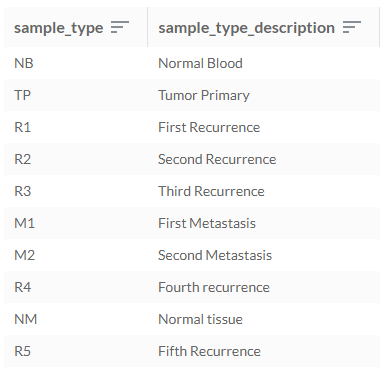

In [8]:
prj = []
src = []
pat = []
smp = []

data_ids = list(df.columns)[1:]

for sub in data_ids:
    meta_data = sub.split('.')
    assert "RNA" == meta_data[5]
    assert "R" == meta_data[4][-1]
    prj.append(meta_data[0])
    src.append(meta_data[1])
    pat.append(meta_data[2])
    smp.append(meta_data[3])

print("Project:", dict(Counter(prj)))
print("Source:", dict(Counter(src)))
print("Patient:", dict(Counter(pat)))
print("Sample:", dict(Counter(smp)))

print(f'total patients: {len(Counter(pat).keys())}')

Project: {'GLSS': 372, 'TCGA': 52}
Source: {'19': 36, 'CU': 60, 'SM': 84, 'MD': 50, 'HF': 70, 'TQ': 7, 'LU': 16, '06': 11, 'DU': 14, 'SN': 26, 'FG': 7, 'HK': 10, 'DH': 2, 'LX': 15, 'SF': 10, 'TM': 2, '14': 4}
Patient: {'0274': 2, 'R005': 2, 'R060': 3, '0017': 4, '47E9': 2, 'A8XE': 2, '00C2': 2, 'CB66': 3, '00B9': 2, '0210': 2, '7304': 2, '0001': 4, '0022': 4, '0267': 4, 'A7RK': 3, 'DF35': 2, '0221': 1, '0048': 1, '6504': 2, 'P024': 1, '4F0A': 3, 'R107': 3, 'R009': 2, '5965': 3, '5963': 2, 'P104': 2, 'B30B': 1, '0046': 1, 'R070': 2, '00C7': 2, 'R101': 4, '0012': 2, '2869': 2, '0027': 3, '0044': 1, 'P069': 2, '0957': 2, '0009': 3, '0279': 3, '0004': 4, '0271': 2, '0280': 2, 'A669': 2, '0041': 2, 'R012': 2, 'P053': 3, 'P101': 3, '0304': 2, '0038': 3, 'R083': 2, 'R064': 3, '2829': 2, '0002': 4, '00C4': 2, 'R080': 2, 'R091': 2, 'R106': 2, '0010': 3, 'R002': 2, 'LP02': 2, '5870': 2, '0013': 2, 'P102': 2, 'P013': 3, '4065': 2, 'R082': 2, '0272': 2, '0035': 2, '0008': 3, '0049': 2, '0019': 1, 

In [9]:
sub3 = []
filtered_tids = []
sample_count = 3
patient_count = dict(Counter(pat))
for k in patient_count.keys():
    # print(k, patient_count[k])
    temporal_ids = []
    if patient_count[k] == sample_count:
        source_sample = []
        for id in data_ids:
            meta_data = id.split('.')
            if meta_data[2] == k:
                temporal_ids.append(id)
                source_sample.append(f"{meta_data[1]}-{meta_data[3]}")
        src_count = dict(Counter([tid.split('.')[1] for tid in sorted(temporal_ids)]))

        if max([src_count[key] for key in src_count]) == sample_count \
            and len(list(set([tid.split('.')[4] for tid in sorted(temporal_ids)]))) == 1 \
            and ['R1', 'R2', 'TP'] == sorted([s.split('-')[1] for s in source_sample]):
            print(f"subject: {k}")
            print(f"source-sample: {sorted(source_sample)} | {src_count} | portion-analyte: {list(set([tid.split('.')[4] for tid in sorted(temporal_ids)]))}")
            for tid in sorted(temporal_ids):
                print(tid)
                filtered_tids.append(tid)
            sub3.append(k)
            print()

filtered_patients = int(len(filtered_tids) / sample_count)
print(f"# filtered temporal samples: {filtered_patients} with {sample_count} progressive (TP, R1, R2) samples.")

subject: CB66
source-sample: ['HF-R1', 'HF-R2', 'HF-TP'] | {'HF': 3} | portion-analyte: ['01R']
GLSS.HF.CB66.R1.01R.RNA.W5T2MP
GLSS.HF.CB66.R2.01R.RNA.5NA0F9
GLSS.HF.CB66.TP.01R.RNA.9MRJMX

subject: A7RK
source-sample: ['TQ-R1', 'TQ-R2', 'TQ-TP'] | {'TQ': 3} | portion-analyte: ['11R']
TCGA.TQ.A7RK.R1.11R.RNA.PKFXB3
TCGA.TQ.A7RK.R2.11R.RNA.BJMJ93
TCGA.TQ.A7RK.TP.11R.RNA.LRGF1D

subject: 4F0A
source-sample: ['HF-R1', 'HF-R2', 'HF-TP'] | {'HF': 3} | portion-analyte: ['01R']
GLSS.HF.4F0A.R1.01R.RNA.WMJWU0
GLSS.HF.4F0A.R2.01R.RNA.U8EJIU
GLSS.HF.4F0A.TP.01R.RNA.GG6762

subject: 5965
source-sample: ['FG-R1', 'FG-R2', 'FG-TP'] | {'FG': 3} | portion-analyte: ['11R']
TCGA.FG.5965.R1.11R.RNA.QSA7Y3
TCGA.FG.5965.R2.11R.RNA.UCBSIY
TCGA.FG.5965.TP.11R.RNA.0XBPNY

subject: 0027
source-sample: ['MD-R1', 'MD-R2', 'MD-TP'] | {'MD': 3} | portion-analyte: ['01R']
GLSS.MD.0027.R1.01R.RNA.E771C5
GLSS.MD.0027.R2.01R.RNA.1RO1LP
GLSS.MD.0027.TP.01R.RNA.9J243C

subject: 0279
source-sample: ['19-R1', '19-R2', '1

In [10]:
filtered_df = df.loc[:, df.columns.isin(filtered_tids)]
filtered_df = filtered_df.reindex(sorted(filtered_df.columns), axis=1)
filtered_df

,GLSS.19.0279.R1.01R.RNA.J1DZC9,GLSS.19.0279.R2.01R.RNA.G733J7,GLSS.19.0279.TP.01R.RNA.R37O1O,GLSS.HF.4F0A.R1.01R.RNA.WMJWU0,GLSS.HF.4F0A.R2.01R.RNA.U8EJIU,GLSS.HF.4F0A.TP.01R.RNA.GG6762,GLSS.HF.57AE.R1.01R.RNA.QYF4I1,GLSS.HF.57AE.R2.01R.RNA.NAVDEK,GLSS.HF.57AE.TP.01R.RNA.D8DT15,GLSS.HF.9A7A.R1.01R.RNA.RQWI9I,GLSS.HF.9A7A.R2.01R.RNA.Q00IRD,GLSS.HF.9A7A.TP.01R.RNA.KGGESL,GLSS.HF.CB66.R1.01R.RNA.W5T2MP,GLSS.HF.CB66.R2.01R.RNA.5NA0F9,GLSS.HF.CB66.TP.01R.RNA.9MRJMX,GLSS.HF.F922.R1.01R.RNA.XNFKVB,GLSS.HF.F922.R2.01R.RNA.5SZ198,GLSS.HF.F922.TP.01R.RNA.43U22A,GLSS.MD.0027.R1.01R.RNA.E771C5,GLSS.MD.0027.R2.01R.RNA.1RO1LP,GLSS.MD.0027.TP.01R.RNA.9J243C,GLSS.SM.R064.R1.01R.RNA.GLLBN3,GLSS.SM.R064.R2.01R.RNA.TUJCN7,GLSS.SM.R064.TP.01R.RNA.W6PIW2,TCGA.FG.5965.R1.11R.RNA.QSA7Y3,TCGA.FG.5965.R2.11R.RNA.UCBSIY,TCGA.FG.5965.TP.11R.RNA.0XBPNY,TCGA.TQ.A7RK.R1.11R.RNA.PKFXB3,TCGA.TQ.A7RK.R2.11R.RNA.BJMJ93,TCGA.TQ.A7RK.TP.11R.RNA.LRGF1D
Gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CMSS1,26.446038,27.000944,32.025694,58.556707,57.852830,32.499702,33.539435,28.411930,40.697986,40.471413,44.400862,26.495458,45.652654,69.141857,41.513165,32.506237,42.736166,55.215389,31.395261,48.859002,44.117700,29.908116,27.260099,17.828630,40.118881,41.346870,22.722971,28.067477,28.982727,25.960538
STX16,99.860372,104.422161,126.156318,22.724986,23.747002,31.417627,22.403354,30.203335,30.676915,32.786515,38.846232,43.396476,15.771102,28.061681,31.536573,24.619422,31.700889,19.431086,20.050733,21.480300,45.597264,48.884761,56.495751,18.633192,31.431786,32.320309,22.001576,40.561056,56.116455,35.465301
TLE4,23.209358,19.561900,31.615145,48.820552,13.052114,22.663886,46.793961,44.078734,37.951477,24.777462,26.251004,21.442147,11.718632,11.868947,56.806393,25.533081,34.723128,11.120648,72.895632,96.452925,65.074070,10.380543,11.952954,8.127578,20.283205,17.131634,10.549622,21.343468,27.467522,14.847250
LRRN1,2.167500,0.433401,5.336610,20.077480,27.622000,66.000960,11.122230,26.176940,19.172719,18.381122,30.268820,48.811640,127.310750,120.850132,50.047356,7.999730,13.838213,117.247460,121.089577,101.425790,137.481300,10.090405,18.670567,3.149691,53.244480,14.485320,79.930672,70.680830,77.726425,28.068071
YKT6,52.902599,65.192139,59.786585,66.396538,75.200924,72.808672,79.729142,114.964130,80.286910,158.157190,186.176690,180.961550,102.254470,51.919720,62.249941,95.362065,95.415774,72.187089,11.058250,13.540128,9.911100,78.258850,73.571330,26.030399,102.325503,53.876787,78.563483,89.567472,91.290736,78.619001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAMTOR3P1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173012,0.189516,0.224356,0.000000,0.000000,0.000000
RNA5SP345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RN7SKP61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
X = filtered_df.T.to_numpy()

tsne = TSNE(n_components=2, random_state=21, perplexity=21)
X_tsne = tsne.fit_transform(X)

plot_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
plot_df['GLASS ID'] = filtered_df.columns

# just for color swap
# i_swap = list(range(42, 45))
# i_ori = list(range(30, 33))
# plot_df.iloc[i_swap], plot_df.iloc[i_ori] = plot_df.iloc[i_ori].copy(), plot_df.iloc[i_swap].copy()

colors = [mcolors.to_hex(color) for color in list(mcolors.CSS4_COLORS)[:10]]
colors = [[c]*3 for c in colors]
colors = [item for sublist in colors for item in sublist]

fig = px.scatter(plot_df, x='x', y='y', hover_name='GLASS ID', color=colors, width=600*1.6, height=600, opacity=0.7)
fig.update_layout(showlegend=False)
fig.update_layout(
    title='t-SNE projection from gene expressions levels for all patients',
    xaxis_title='TSNE-1',
    yaxis_title='TSNE-2',
    template='plotly_white',
    font=dict(
        family='Arial, sans-serif',
        size=12,
        color='Black'
    )
)
fig.show()

### Patient Demograph

In [12]:
survival_df = syn.tableQuery("SELECT * FROM syn31121181").asDataFrame()
survival_df["case_overall_survival_mo"] = survival_df["case_overall_survival_mo"].astype(float)
print(Counter(survival_df["case_vital_status"]))

aggressive = set([bc.split("-")[2] for bc in survival_df[survival_df["case_overall_survival_mo"] <= 12]["case_barcode"]]).intersection(set(sub3))
nonaggressive = set([bc.split("-")[2] for bc in survival_df[survival_df["case_overall_survival_mo"] >= 80]["case_barcode"]]).intersection(set(sub3))

aggressive_barcode = [s for s in survival_df["case_barcode"] if s.split('-')[2] in aggressive]
nonaggressive_barcode = [s for s in survival_df["case_barcode"] if s.split('-')[2] in nonaggressive]

survival_df[survival_df["case_barcode"].isin(aggressive_barcode + nonaggressive_barcode)].sort_values(by=['case_overall_survival_mo'], ascending=True)

Counter({'dead': 299, 'alive': 94, nan: 55})


,case_barcode,case_project,case_source,case_sex,case_age_diagnosis_years,case_vital_status,case_overall_survival_mo
278_1,GLSS-19-0279,GLSS,19,male,34,dead,11.0
319_1,GLSS-HF-57AE,GLSS,HF,female,59,dead,11.0
140_1,GLSS-SF-0027,GLSS,SF,male,56,alive,54.0
28_1,GLSS-MD-0027,GLSS,MD,male,30,dead,80.0
323_1,GLSS-HF-4F0A,GLSS,HF,male,35,dead,139.0
322_1,GLSS-HF-CB66,GLSS,HF,female,44,dead,175.0


Considering 0279 as aggressive (11M) and 0027 as non-aggressive (80M) subject for our case study.

In [13]:
primary_baseline_subjects = list(set([c.split('.')[2] for c in filtered_df.columns]) - set(["0027", "0279"]))
primary_baseline_barcode = [c for c in list(survival_df['case_barcode']) if c.split('-')[-1] in primary_baseline_subjects]
primary_baseline_df = survival_df[survival_df["case_barcode"].isin(primary_baseline_barcode)].sort_values(by=['case_overall_survival_mo'], ascending=True)
baseline_df = primary_baseline_df[(primary_baseline_df["case_overall_survival_mo"] > 12) & (primary_baseline_df["case_overall_survival_mo"] < 80)]
baseline_df # ['5965', 'F922', 'A7RK', 'R064', '9A7A']

,case_barcode,case_project,case_source,case_sex,case_age_diagnosis_years,case_vital_status,case_overall_survival_mo
80_1,TCGA-FG-5965,TCGA,FG,female,39,dead,37.0
313_1,GLSS-HF-F922,GLSS,HF,male,45,dead,38.0
82_1,TCGA-TQ-A7RK,TCGA,TQ,male,29,alive,40.0
158_1,GLSS-SM-R064,GLSS,SM,female,56,dead,42.0
311_1,GLSS-HF-9A7A,GLSS,HF,male,49,dead,75.0


Average of this 5 patients will be considered as baseline from now on. It has a good distribution of 37 to 75 months of survival with 3 male and 2 female patients, 1 alive and 4 dead.

### Patient Treatment History

In [14]:
treatment_df = syn.tableQuery("SELECT * FROM syn31121219").asDataFrame()
treatment_df[treatment_df["case_barcode"]=="GLSS-MD-0027"]

,case_barcode,surgery_number,sample_barcode,surgical_interval_mo,histology,grade,idh_status,codel_status,who_classification,mgmt_methylation,surgery_type,surgery_indication,surgery_extent_of_resection,surgery_laterality,surgery_location,treatment_tmz,treatment_tmz_cycles,treatment_tmz_cycles_6,treatment_tmz_cycles_notes,treatment_concurrent_tmz,treatment_radiotherapy,treatment_radiation_dose_gy,treatment_radiation_fractions,treatment_radiation_other,treatment_chemotherapy_other,treatment_chemotherapy_other_cycles,comments,idh_codel_subtype,treatment_alkylating_agent,mgmt_methylation_method
560_1,GLSS-MD-0027,1,GLSS-MD-0027-TP,0,Astrocytoma,II,IDHmut,noncodel,"Diffuse Astrocytoma, IDH-mutant",NaN,Craniotomy,Therapeutic,Subtotal,Left,Temporal lobe,0,NaN,NaN,NaN,NaN,1,50.4,28,IMRT,NaN,NaN,low grade Astrocytoma,IDHmut-noncodel,0,NaN
561_1,GLSS-MD-0027,2,GLSS-MD-0027-R1,55,Astrocytoma,III,IDHmut,noncodel,"Anaplastic Astrocytoma, IDH-mutant",NaN,Craniotomy,Relapse,Subtotal,Left,Temporal lobe,1,12,1,NaN,NaN,0,NaN,NaN,NaN,"6-thioguanine, Capecitabine, Celecoxib, Lomustine",6,Anaplastic Astrocytoma with necrosis,IDHmut-noncodel,1,NaN
567_1,GLSS-MD-0027,3,GLSS-MD-0027-R2,76,Glioblastoma,IV,IDHmut,noncodel,"Glioblastoma, IDH-mutant",NaN,Craniotomy,Relapse,Subtotal,Left,Temporal lobe,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Bevacizumab,1,NaN,IDHmut-noncodel,0,NaN


In [15]:
treatment_df[treatment_df["case_barcode"]=="GLSS-19-0279"]

,case_barcode,surgery_number,sample_barcode,surgical_interval_mo,histology,grade,idh_status,codel_status,who_classification,mgmt_methylation,surgery_type,surgery_indication,surgery_extent_of_resection,surgery_laterality,surgery_location,treatment_tmz,treatment_tmz_cycles,treatment_tmz_cycles_6,treatment_tmz_cycles_notes,treatment_concurrent_tmz,treatment_radiotherapy,treatment_radiation_dose_gy,treatment_radiation_fractions,treatment_radiation_other,treatment_chemotherapy_other,treatment_chemotherapy_other_cycles,comments,idh_codel_subtype,treatment_alkylating_agent,mgmt_methylation_method
124_1,GLSS-19-0279,1,GLSS-19-0279-TP,0,Glioblastoma,IV,IDHmut,NaN,"Glioblastoma, IDH-mutant",NaN,Craniotomy,NaN,Total,Right,Frontal lobe,1,4,0,NaN,1,1,60,30,IMRT,0,NaN,NaN,IDHmut-noncodel,1,NaN
125_1,GLSS-19-0279,2,GLSS-19-0279-R1,9,Glioblastoma,IV,NaN,NaN,"Glioblastoma, NOS",NaN,Craniotomy,NaN,Subtotal,NaN,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,IDHmut-noncodel,0,NaN
126_1,GLSS-19-0279,3,GLSS-19-0279-R2,9,Glioblastoma,IV,NaN,NaN,"Glioblastoma, NOS",NaN,Craniotomy,NaN,Subtotal,NaN,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,IDHmut-noncodel,0,NaN
